In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.memory import MemorySaver

In [3]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [4]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
        }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
        }

The graph goes N1->N2->N1... but breaks after count reaches 3.

In [5]:
def should_continue(state):
    return state["count"] < 3

In [11]:
agent = StateGraph(AgentState)
agent.add_node("Node1",node1)
agent.add_node("Node2",node2)
agent.add_edge("Node1", "Node2")
agent.add_conditional_edges("Node2", 
                            should_continue, 
                            {True: "Node1", False: END})
agent.set_entry_point("Node1")

In [12]:
memory = MemorySaver()
graph = agent.compile(checkpointer=memory)

In [13]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count":0, "scratch":"hi"},thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

Look at current state

In [14]:
graph.get_state(thread)

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b8f-6523-8004-4d7c6f98a4bc'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '1', 'step': 4, 'parents': {}}, created_at='2025-01-16T11:43:45.799709+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b82-6fb5-8003-79ff4cf830ed'}}, tasks=())

Look at state history

In [15]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b8f-6523-8004-4d7c6f98a4bc'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '1', 'step': 4, 'parents': {}}, created_at='2025-01-16T11:43:45.799709+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b82-6fb5-8003-79ff4cf830ed'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b82-6fb5-8003-79ff4cf830ed'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '1', 'step': 3, 'parents': {}}, created_at='2025-01-16T11:43:45.794654+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff

In [16]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b8f-6523-8004-4d7c6f98a4bc'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b82-6fb5-8003-79ff4cf830ed'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b81-6b46-8002-0245bec54bf0'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b78-6154-8001-e1a408fee7e9'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b6e-661f-8000-78e40979e49e'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b64-696a-bfff-de2cda376455'}} 0


In [17]:
states

[{'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1efd3ff2-4b8f-6523-8004-4d7c6f98a4bc'}},
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1efd3ff2-4b82-6fb5-8003-79ff4cf830ed'}},
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1efd3ff2-4b81-6b46-8002-0245bec54bf0'}},
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1efd3ff2-4b78-6154-8001-e1a408fee7e9'}},
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1efd3ff2-4b6e-661f-8000-78e40979e49e'}},
 {'configurable': {'thread_id': '1',
   'checkpoint_ns': '',
   'checkpoint_id': '1efd3ff2-4b64-696a-bfff-de2cda376455'}}]

In [18]:
states[-3]

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd3ff2-4b78-6154-8001-e1a408fee7e9'}}

In [19]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b78-6154-8001-e1a408fee7e9'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '1', 'step': 1, 'parents': {}}, created_at='2025-01-16T11:43:45.790190+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b6e-661f-8000-78e40979e49e'}}, tasks=(PregelTask(id='99aac17d-58af-3f90-cd88-e74cb4661c3e', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),))

Go Back in Time

In [20]:
graph.invoke(None, states[-3])

node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

In [21]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd4004-85fa-6d54-8004-4e8d1cea1606'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd4004-85f8-6639-8003-d6e8ea8083b1'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd4004-85f3-67cf-8002-2f6a58d03f2f'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b8f-6523-8004-4d7c6f98a4bc'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b82-6fb5-8003-79ff4cf830ed'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b81-6b46-8002-0245bec54bf0'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b78-6154-8001-e1a408fee7e9'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b6e-661f-8000-78e40979e49e'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

In [22]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd4004-85fa-6d54-8004-4e8d1cea1606'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b78-6154-8001-e1a408fee7e9', 'step': 4, 'parents': {}}, created_at='2025-01-16T11:51:55.109307+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd4004-85f8-6639-8003-d6e8ea8083b1'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd4004-85f8-6639-8003-d6e8ea8083b1'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efd3ff2-4b78-6154-8001-e1a408fee7e9', 'step': 3, 'pa

Modify State

In [23]:
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count":0, "scratch":"hi"},thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

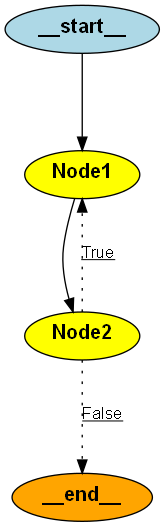

In [24]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [25]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-ddb8-66fa-8004-cc5e87106faf'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-ddb2-6e51-8003-3435d20629e4'}} 3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-ddb0-66ec-8002-509b660705b6'}} 2
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-ddac-6c0c-8001-920119baac05'}} 1
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-dda7-6dfd-8000-cf177f7f9730'}} 0
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-dda5-66fb-bfff-e256eaf945e5'}} 0


In [26]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-ddac-6c0c-8001-920119baac05'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '2', 'step': 1, 'parents': {}}, created_at='2025-01-16T11:53:51.678977+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-dda7-6dfd-8000-cf177f7f9730'}}, tasks=(PregelTask(id='260957be-2b92-812d-6de8-61d81cb5c544', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),))

In [27]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-ddac-6c0c-8001-920119baac05'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '2', 'step': 1, 'parents': {}}, created_at='2025-01-16T11:53:51.678977+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-dda7-6dfd-8000-cf177f7f9730'}}, tasks=(PregelTask(id='260957be-2b92-812d-6de8-61d81cb5c544', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),))

In [28]:
graph.update_state(thread2,save_state.values)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd400d-ede8-65c5-8005-dde32f228a30'}}

In [29]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd400d-ede8-65c5-8005-dde32f228a30'}}, metadata={'source': 'update', 'writes': {'Node2': {'lnode': 'node_1', 'scratch': 'hello', 'count': -3}}, 'thread_id': '2', 'step': 5, 'parents': {}}, created_at='2025-01-16T11:56:07.598842+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-ddb8-66fa-8004-cc5e87106faf'}}, tasks=(PregelTask(id='a5c958b8-db8e-ed08-5022-8bd9647a6ec2', name='Node1', path=('__pregel_pull', 'Node1'), error=None, interrupts=(), state=None, result=None),)) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4008-ddb8-66fa-8004-cc5e87106faf'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_i

with as_node

In [30]:
graph.update_state(thread2,save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1efd4010-5751-65cc-8006-d357f4ef2acc'}}

In [31]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4010-5751-65cc-8006-d357f4ef2acc'}}, metadata={'source': 'update', 'writes': {'Node1': {'lnode': 'node_1', 'scratch': 'hello', 'count': -3}}, 'thread_id': '2', 'step': 6, 'parents': {}}, created_at='2025-01-16T11:57:12.338990+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd400d-ede8-65c5-8005-dde32f228a30'}}, tasks=(PregelTask(id='b8913800-6cae-8b19-5812-c484aea451d4', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),)) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd400d-ede8-65c5-8005-dde32f228a30'}}, metadata={'source': 'update', 'writes': {'Node2': {'lnode': 'node_1', 'scratch'

In [32]:
graph.invoke(None,thread2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

In [33]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4011-297b-668a-800b-7533e0d9e5b3'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'thread_id': '2', 'step': 11, 'parents': {}}, created_at='2025-01-16T11:57:34.376308+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4011-2978-6f57-800a-e8d7bdcf52ed'}}, tasks=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efd4011-2978-6f57-800a-e8d7bdcf52ed'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'thread_id': '2', 'step': 10, 'parents': {}}, created_at='2025-01-16T11:57:34.375304+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': 